# Ames Housing Data - Housing Price Prediction

The entire project is split into three Jupyter notebooks:
1. EDA and data cleaning,
2. Preprocessing and feature engineering,
3. Automated Feature Selection
4. Model tuning and insights

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import featuretools as ft
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV 
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

sns.set_style('ticks')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 3000)

%matplotlib inline

## Introduction

In this appendix, I used the featuretools library to automate the feature engineering and preprocessing process. Compared to the manual feature cleaning that I did in notebook #2, this not only saves time, but also generates many more potentially useful features. I then evaluated the resulting features using the same model I developed in the previous notebook.

In summary, while featuretools greatly saved the amount of time needed for feature preprocessing, in this particular case, it did not outperform manual feature cleaning.

## Contents:-

1. Build preprocessing function
2. Check preprocessing function
3. Data transformations
4. Final preprocessing workflow
5. Export preorcessed data

## Preprocessing with featuretools

### Import data

In [2]:
# import train
train = pd.read_csv ("datasets/train.csv")

# check df
print(train.columns)
train.info()

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood De

## Convert data to int/float32

To save time during featuretools preprocessing, columns were first converted to less memory-intensive types.

In [3]:
def convert_columns(df):  
    for col in df.columns:    
        col_type = df[col].dtype
        if (col_type == 'object'):
                df[col] = df[col].astype('category')    
        if (col_type == 'int64'):
                df[col] = df[col].astype('int32')   
        if (col_type == 'float64'):
                df[col] = df[col].astype('float32')  
    return df

for col in train:
    convert_columns(train)
    
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               2051 non-null   int32   
 1   PID              2051 non-null   int32   
 2   MS SubClass      2051 non-null   int32   
 3   MS Zoning        2051 non-null   category
 4   Lot Frontage     1721 non-null   float32 
 5   Lot Area         2051 non-null   int32   
 6   Street           2051 non-null   category
 7   Alley            140 non-null    category
 8   Lot Shape        2051 non-null   category
 9   Land Contour     2051 non-null   category
 10  Utilities        2051 non-null   category
 11  Lot Config       2051 non-null   category
 12  Land Slope       2051 non-null   category
 13  Neighborhood     2051 non-null   category
 14  Condition 1      2051 non-null   category
 15  Condition 2      2051 non-null   category
 16  Bldg Type        2051 non-null   category


## Separate x and y columns

In [4]:
x = train.loc[:, train.columns != 'SalePrice']
y = train[['SalePrice']]

print(x.shape)
print(y.shape)

(2051, 80)
(2051, 1)


## Create entities

In [5]:
entity_set_x = ft.EntitySet(id = 'x')

entity_set_x = entity_set_x.add_dataframe(dataframe_name='x',dataframe = x)

In [6]:
# check that it has read all the data in
entity_set_x

Entityset: x
  DataFrames:
    x [Rows: 2051, Columns: 80]
  Relationships:
    No relationships

## Create primitives

In [7]:
list_of_primitives = ft.primitives.list_primitives()
list_of_primitives[list_of_primitives.type == 'aggregation']

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,avg_time_between,aggregation,False,False,Computes the average number of seconds between...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = Double) (Semanti...
1,sum,aggregation,True,True,"Calculates the total addition, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
2,num_true,aggregation,True,False,Counts the number of `True` values.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = IntegerNullable)...
3,trend,aggregation,False,False,Calculates the trend of a column over time.,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",<ColumnSchema (Semantic Tags = ['numeric'])>
4,max,aggregation,True,True,"Calculates the highest value, ignoring `NaN` v...",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
5,time_since_last,aggregation,False,False,Calculates the time elapsed since the last dat...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = Double) (Semanti...
6,any,aggregation,True,False,Determines if any value is 'True' in a list.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = Boolean)>
7,mode,aggregation,False,False,Determines the most commonly repeated value.,<ColumnSchema (Semantic Tags = ['category'])>,None
8,first,aggregation,False,False,Determines the first value in a list.,<ColumnSchema>,None
9,skew,aggregation,False,False,Computes the extent to which a distribution di...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>


In [8]:
list_of_primitives[list_of_primitives.type == 'transform']


,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
22,url_to_tld,transform,False,False,Determines the top level domain of a url.,<ColumnSchema (Logical Type = URL)>,<ColumnSchema (Logical Type = Categorical) (Se...
23,is_year_start,transform,True,True,Determines if a date falls on the start of a y...,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = BooleanNullable)>
24,is_null,transform,True,True,Determines if a value is null.,<ColumnSchema>,<ColumnSchema (Logical Type = Boolean)>
25,rolling_std,transform,False,False,Calculates the standard deviation of entries o...,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",<ColumnSchema (Logical Type = Double) (Semanti...
26,isin,transform,True,True,Determines whether a value is present in a pro...,<ColumnSchema>,<ColumnSchema (Logical Type = Boolean)>
...,...,...,...,...,...,...,...
113,and,transform,True,True,Performs element-wise logical AND of two lists.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = BooleanNullable)>
114,rolling_mean,transform,False,False,Calculates the mean of entries over a given wi...,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",<ColumnSchema (Logical Type = Double) (Semanti...
115,equal,transform,True,True,Determines if values in one list are equal to ...,<ColumnSchema>,<ColumnSchema (Logical Type = BooleanNullable)>
116,haversine,transform,False,False,Calculates the approximate haversine distance ...,<ColumnSchema (Logical Type = LatLong)>,<ColumnSchema (Semantic Tags = ['numeric'])>


In [9]:
# select list of aggregation primitives to use on data
agg_primitives = ['median','sum','n_most_common','count','time_since_last','avg_time_between','mean',\
                 'skew']

In [10]:
# select list of transform primitives to use on data
trans_primitives = ['diff','greater_than_equal_to','time_since','subtract_numeric','divide_numeric',\
                   'is_null','percentile','less_than']

## Create features using the deep feature synthesis (dfs) object

Using the above primitives, featuretools produced 4895 features.

In [11]:
features, feature_names = ft.dfs(entityset = entity_set_x,
                                target_dataframe_name = 'x',
                                agg_primitives=agg_primitives,
                                trans_primitives=trans_primitives,
                                max_depth =1,
                                verbose=True)

Built 4895 features
Elapsed: 00:05 | Progress: 100%|████████████████████████████████████████████████


In [12]:
features.shape


(2051, 4895)

## Feature cleaning

In [13]:
# drop columns with inf and nan
x = features.copy()
x = x.reset_index()

x = x.replace([np.inf, -np.inf], np.nan)
x = x.dropna(axis=1, how='any')

## Model-building

### One-hot encoding

In [14]:
train_dummies = pd.get_dummies(x, drop_first = True)
train_dummies.shape

(2051, 2215)

### Train-test-split

In [15]:
# train test split
np.random.seed(100)
xtrain, xtest, ytrain, ytest = train_test_split(train_dummies, y, test_size = 0.3, random_state = 7)
    
print(xtrain.shape)
print(ytrain.shape)

(1435, 2215)
(1435, 1)


### Scale data


In [16]:
from scipy.special import boxcox1p

# scale data - standardscaler
scaler = StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# ytrain_scaled = scaler.fit_transform(ytrain)
# ytest_scaled = scaler.transform(ytest)

# transform y
ytrain['SalePrice'] = boxcox1p(ytrain['SalePrice'],0.15)
ytest['SalePrice'] = boxcox1p(ytest['SalePrice'],0.15)

### Hyperparameter tuning

In [17]:
import numpy as np
enet_alpha = np.arange(0, 1, 0.5)
enet_ratio = [.01, .1, .2, .3, .5, .7, .9, .95, .99, 1]

# fits multiple alphas and rhos
enetcv = ElasticNetCV(alphas = enet_alpha, l1_ratio = enet_ratio, cv = 3, n_jobs = -1, verbose=True)
enetcv = enetcv.fit(xtrain_scaled, ytrain)

# print('optimal enet alpha: ', enetcv.alpha_)
# print('optimal enet lambda: ', enetcv.l1_ratio_)
# print('best elastic net R2: ', enetcv.score(xtrain_scaled, ytrain))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
............................................................[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.4s finished


In [18]:
# instantiate models with previously selected hyperparameters
enet = ElasticNet(alpha = enetcv.alpha_, l1_ratio = enetcv.l1_ratio_)

## CV (train)

In [19]:
# define CV function
nfolds = 5 
np.random.seed(100)

def crossval(model, x, y):
    kf = KFold(nfolds, shuffle = True, random_state = 7)
    rmse = np.sqrt(-cross_val_score(model, x, y, cv = kf, scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(model, x, y, cv = kf)
    return 'mean CV R2:', r2.mean(), \
            'mean CV RMSE:', rmse.mean(), \
            'CV R2 variance:', r2.var(), \
            'CV RMSE variance:', rmse.var()

In [20]:
# baseline model
# use dummy regressor to predict using mean
dummy_regressor = DummyRegressor()
print('Baseline model: \n', crossval(dummy_regressor, xtrain_scaled, ytrain))

# elastic net regression
print('ELASTIC NET: \n', crossval(enet, xtrain_scaled, ytrain))


Baseline model: 
 ('mean CV R2:', -0.009097800823119683, 'mean CV RMSE:', 2.5033834921525204, 'CV R2 variance:', 8.25759758736003e-05, 'CV RMSE variance:', 0.03571010636266923)
ELASTIC NET: 
 ('mean CV R2:', 0.860158851426155, 'mean CV RMSE:', 0.9146706638354949, 'CV R2 variance:', 0.0020894786305008556, 'CV RMSE variance:', 0.01042208021440859)


## Model performance

The model performance using automatically preprocessed features are summarised below:

Model	R2	RMSE
Train - baseline model	-0.00909	2.50338
Test - baseline model	-0.00106	2.47530
Train - elastic net	0.86119	0.91617
Test - elastic net	0.90678	0.75532
For comparison, the model score using manual preprocessing are:

Model	R2	RMSE
Train - elastic net regression	0.91801	0.71084
Test - elastic net regression	0.91851	0.71937
One can see that manual preprocessing produced a better score in this case. This is likely because as this dataset had relatively few features, manual preprocessing was able to better identify specific ways to treat each column, instead of applying a blanket treatment to all columns.

The features selected in this case also greatly differ from those selected by the model from manually preprocessed data. For instance, the top 5 features in the automated model are:

Gr Liv Area < BsmtFin SF 1 (whether Gr Liv Area is less than BsmtFin SF 1)
Mo Sold < Bsmt Full Bath
Overall Qual
Kitchen AbvGr - Overall Qual (Kitchen AbvGr minus Overall Qual)
Overall Qual / Yr Sold (Overall Qual divide by Yr Sold)
Whereas in the original model, the top five coefficients are:

Gr Liv Area
Overall Qual
Overall Cond
age_sold
Lot Area
The coefficients of the original model are also a lot easier to interprete in this case.

In [21]:
# --------------------------------------- DEFINE ERROR METRICS ---------------------------------------
def rmse(ytest, ypred):
    return np.sqrt(mean_squared_error(ytest, ypred))

# ----------------------------------------- FIT BASELINE MODEL ----------------------------------------
# use dummy regressor to predict using mean
dummy_regressor = DummyRegressor()
baseline_mod = dummy_regressor.fit(xtrain_scaled, ytrain)
baseline_pred = dummy_regressor.predict(xtest_scaled)

print(f'baseline R2: {dummy_regressor.score(xtest_scaled, ytest)}')
print(f'baseline RMSE: {rmse(ytest, baseline_pred)}')

# --------------------------------------- FIT ELASTIC NET MODEL ---------------------------------------
# fit model to train data
enet_mod = enet.fit(xtrain_scaled, ytrain)
# predict on test data
ypred = enet_mod.predict(xtest_scaled)
# evaluate model performance
print('elastic net test R2: ', enet_mod.score(xtest_scaled, ytest))
print('elastic net test RMSE: ', rmse(ytest, ypred))

baseline R2: -0.0010643924624773593
baseline RMSE: 2.4753085804577317
elastic net test R2:  0.9079907788014394
elastic net test RMSE:  0.7504366181954224


## Coefficients

the model produced 982 non-zero coefficients.


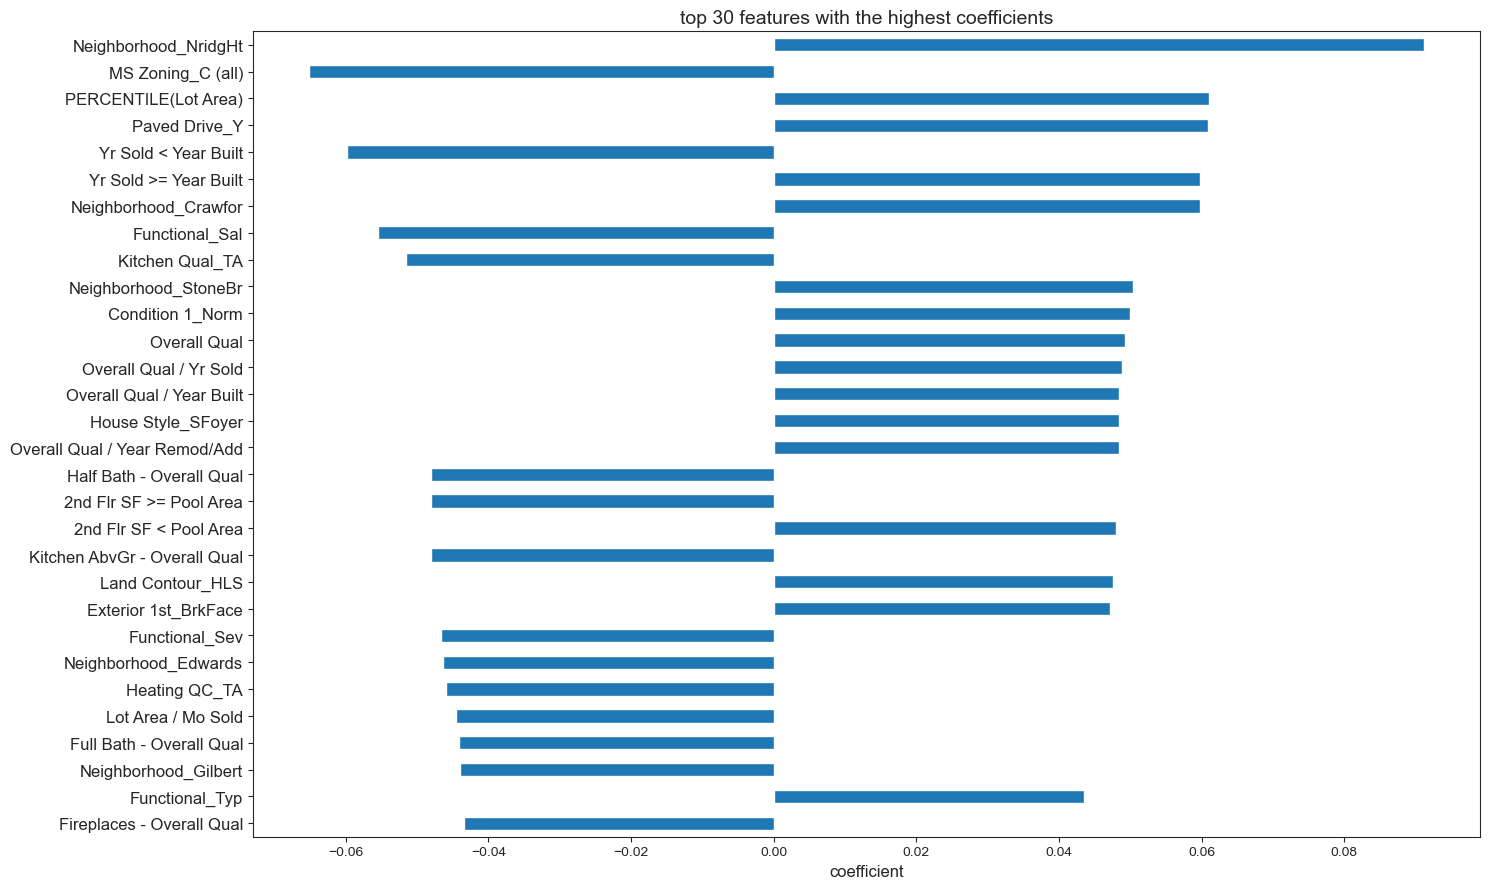

In [22]:
# ---------------------------------------- IDENTIFYING TOP FEATURES ----------------------------------------

# get list of coefficients that are not 0
coef_labels = [col for col in train_dummies.columns if col != 'SalePrice'] # column labels
enet_coef = pd.DataFrame(enet_mod.coef_, index = coef_labels)              # get coefficients from best model
enet_coef = enet_coef[enet_coef[0] != 0]                                   # get non-zero coefficients
print(f'the model produced {enet_coef.shape[0]} non-zero coefficients.')

# sort by absolute values
enet_coef = enet_coef.reindex(enet_coef[0].abs().sort_values(ascending=True).index)

# plot top 30 coefficients
enet_coef.tail(30).plot.barh(figsize=(15,9), legend = None)
plt.title('top 30 features with the highest coefficients',fontsize=14)
plt.xlabel('coefficient', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

## Residuals

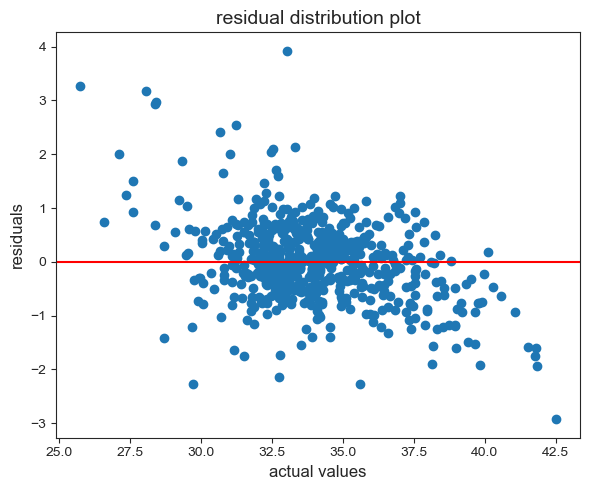

In [23]:
# plot residuals
resid = ypred - ytest.SalePrice

plt.rcParams['figure.figsize'] = (6.0, 5.0)
plt.scatter(ytest.SalePrice, resid)
plt.axhline(0, linestyle='-', color='r')
plt.title('residual distribution plot',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.tight_layout()

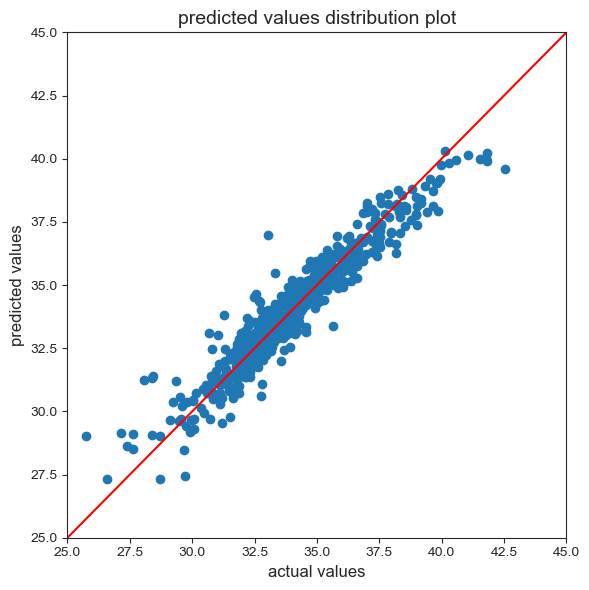

In [24]:
# plot ypred vs ytrue
fig, ax = plt.subplots(figsize=(6.0, 6.0))
ax.scatter(ytest.SalePrice, ypred)
ax.set_title('predicted values distribution plot',fontsize=14)
ax.set_xlabel('actual values',fontsize=12)
ax.set_ylabel('predicted values',fontsize=12)
ax.set_xlim(25,45)
ax.set_ylim(25,45)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.tight_layout()